<a href="https://colab.research.google.com/github/rdemarqui/traffic_prediction_and_congestion/blob/main/LTE_Cell_Traffic_Grow_and_Congestion_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LTE Cell Traffic Grow and Congestion Forecasting

## I. Introduction

This code was writen based on paper:
* D. Chmieliauskas and D. Guršnys, "LTE Cell Traffic Grow and Congestion Forecasting," 2019 Open Conference of Electrical, Electronic and Information Sciences (eStream), 2019, pp. 1-5, doi: 10.1109/eStream.2019.8732145. PDF found on: https://www.researchgate.net/publication/345446849_LTE_Cell_Traffic_Grow_and_Congestion_Forecasting

The purpose of this work was to provide a replicable code for the [paperswithcode.com](https://paperswithcode.com/). For more details, go to: https://paperswithcode.com/paper/lte-cell-traffic-grow-and-congestion.

**Notes:**
1. The study and data cleaning steps are beyond the scope of this work, being done beforehand and omitted from the code.
2. The results shown in this work were obtained using real data from a cellular network, but due to compliance reasons, these data can't be shared.
3. There are some differences between the method proposed by the authors and this work. This may have occurred due to lack of information in the paper or our judgment that the changes could obtain better accuracy. In any case, these differences were mentioned throughout the code.

In [ ]:
import pandas as pd
from scipy import stats
from sklearn import metrics
from datetime import datetime, timedelta
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (8,5)

from fbprophet import Prophet

### Data Transform

The paper does not mention any form of data normalization, but in our studies we've seen that the Prophet achieve better accuracy when we apply the Box-Cox method for this solution.

In [ ]:
# Creating inverse Box-Cox
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

### Evaluation Metrics

As evaluation metrics, the authors worked with:
* Explained Variance Score
* R² Score
* Mean Average Percentage Error (MAPE)

Despite being widely used, the MAPE metric has several flaws, among them the high sensitivity to outliers, which are frequently found in the data of our study. For this reason, we will use SMAPE instead, which is a slightly more robust metric. For more details, see the work of Chris Tofallis in the study entitled "*A better measure of relative prediction accuracy for model selection and model estimation*".

In [ ]:
def smape_metric(y_true, y_pred):
  smape = 1/len(y_true) * np.sum(2 * np.abs(y_true-y_pred) / (np.abs(y_true) + np.abs(y_pred)))
  return smape

metric_cols = ['sMAPE', 'EVS', 'R2']

def timeseries_evaluation_metrics_func(y_true, y_pred):
  sMAPE = smape_metric(y_true, y_pred)
  EVS = metrics.explained_variance_score(y_true, y_pred)
  R2 = metrics.r2_score(y_true, y_pred)

  return [sMAPE, EVS, R2]

## II. Total Daily Traffic Forecasting

### Getting Data

**Note:** In the original paper authors used 180 days, where 5 months was used for training and one month for forecast testing. In this work we used 1.5 years for training, mantaining 28 days for forecast testing. By doing this, we can take advantage of the annual seasonality, not originally used by the authors.

In [ ]:
# Opening daily cell data
daily_traffic = pd.read_csv('df_daily.csv', sep=';')
daily_traffic.head(10)

,Cell,Band(MHz),Date,Data_Volume
0,cell0001,1800,2019-01-01,9.406620e+06
1,cell0001,1800,2019-01-02,3.229836e+06
2,cell0001,1800,2019-01-03,5.869033e+06
3,cell0001,1800,2019-01-04,6.525841e+06
4,cell0001,1800,2019-01-05,7.415637e+06
5,cell0001,1800,2019-01-06,1.244459e+07
6,cell0001,1800,2019-01-07,1.201881e+07
7,cell0001,1800,2019-01-08,1.411982e+07
8,cell0001,1800,2019-01-09,1.780909e+07
9,cell0001,1800,2019-01-10,1.164014e+07


In [ ]:
# Renaming columns for Prophet standard, where ds its the date
# and y it's a target variable Data_Volume
daily_traffic.columns = ['Cell', 'Band(MHz)', 'ds', 'y']
daily_traffic['ds'] = pd.to_datetime(daily_traffic['ds'])

In [ ]:
# Checking cell quantity and data range
list_cells = daily_traffic.Cell.unique()
print(f'Dataset have {len(list_cells)} unique cells',
      f'with date between {min(daily_traffic.ds)} and {max(daily_traffic.ds)}.')

Dataset have 159 unique cells with date between 2019-01-01 00:00:00 and 2021-01-28 00:00:00.


In [ ]:
# Splitting dataset
n_days_forecast = 28
train_ini, train_end = '2019-01-01', '2020-07-01'
val_ini, val_end = train_end, datetime.strptime(train_end, "%Y-%m-%d") + timedelta(days=n_days_forecast)

df_daily_train = daily_traffic[(daily_traffic['ds'] >= train_ini) & (daily_traffic['ds'] < train_end)].copy()
df_daily_val = daily_traffic[(daily_traffic['ds'] >= val_ini) & (daily_traffic['ds'] < val_end)].copy()

### Forecasting

**Note:** Authors do not make it clear whether they used the standard/automatic hyperparameters or whether they did tuning. In this work, we customized all the seasonality in order to get better performance. In this way it's possible to test several configurations and see which one performs best.

In [ ]:
# Parameters
daily_params = [# Config01
                [{'changepoint_prior_scale': 0.05},                                     # Trend sensibility
                  {'fourier_order': 3, 'mode': 'multiplicative', 'prior_scale': 0.1},   # Weekly Hyperparameters
                  {'fourier_order': 4, 'mode': 'additive', 'prior_scale': 1}],          # Yearly Hyperparameters

                # Config02
                [{'changepoint_prior_scale': 0.05},
                  {'fourier_order': 3, 'mode': 'multiplicative', 'prior_scale': 0.05},
                  {'fourier_order': 4, 'mode': 'additive', 'prior_scale': 1}],

                # Config03
                [{'changepoint_prior_scale': 0.05},
                  {'fourier_order': 3, 'mode': 'multiplicative', 'prior_scale': 0.1},
                  {'fourier_order': 4, 'mode': 'additive', 'prior_scale': 0.1}]
]

In [ ]:
final_result_daily = pd.DataFrame()

for cell in list_cells[:]:
  #print(cell)
  n_config = 1
  # Filtering cell
  df_train_temp = df_daily_train[df_daily_train['Cell']==cell].copy()
  df_val_temp = df_daily_val[df_daily_val['Cell']==cell].copy()

  # Applying Box-Cox
  df_train_temp['y'], lambda_prophet = stats.boxcox(df_train_temp['y'])

  # Executing all configurations
  for params in daily_params:
    config = 'conf_' + str(n_config).zfill(len(str(len(daily_params))))

    # Instantiating the model
    m = Prophet(yearly_seasonality=False,
                weekly_seasonality=False,
                daily_seasonality=False,
                uncertainty_samples=0,      # Zeroed to speed up forecast
                **params[0])

    # Weekly seasonality
    m.add_seasonality(name='weekly', period=7, **params[1])

    # Yearly seasonality
    m.add_seasonality(name='yearly', period=365.25, **params[2])

    # Fit
    m.fit(df_train_temp)

    # Create future dataset
    future = m.make_future_dataframe(n_days_forecast, freq='d')

    # Forecast
    forecast = m.predict(future)

    # Applying inverse Box-Cox in forecast data
    forecast['yhat'] = inverse_boxcox(forecast['yhat'], lambda_prophet)

    # Insert config number
    forecast['configuration'] = config

    # Mergin forecasted and actual data
    temp_result_daily = pd.merge(df_val_temp,
                                 forecast[['ds', 'yhat', 'configuration']],
                                 left_on='ds',
                                 right_on='ds',
                                 how='inner')

    final_result_daily = pd.concat([final_result_daily, temp_result_daily])

    n_config += 1

### Evaluating

#### LTE Traffic Forecasting Accuracy Overall Result

In [ ]:
# Eveluating results for each configuration
evaluating_cols = metric_cols + ['Configuration']
overall_result_daily = pd.DataFrame(columns= evaluating_cols)
full_eval = []
daily_configurations = final_result_daily.configuration.unique()

for configuration in daily_configurations:
  temp_df = final_result_daily[final_result_daily['configuration']==configuration]
  temp_eval = timeseries_evaluation_metrics_func(temp_df.y, temp_df.yhat)
  temp_eval.append(configuration)
  full_eval.append(temp_eval)

overall_result_daily = pd.concat([overall_result_daily,
                                  pd.DataFrame(full_eval, columns= evaluating_cols)])
overall_result_daily.round(5)

,sMAPE,EVS,R2,Configuration
0,0.29390,0.85330,0.85234,conf_1
1,0.29032,0.87967,0.87854,conf_2
2,0.29395,0.88292,0.88147,conf_3


In [ ]:
# Eveluating results for each configuration
evaluating_cols_1 = metric_cols + ['Configuration', 'cell']
individual_result_daily = pd.DataFrame(columns=evaluating_cols_1)
ind_eval = []
daily_configurations = final_result_daily.configuration.unique()
cells_eval = final_result_daily['Cell'].unique()

for cell in cells_eval:
  temp_cell_df = final_result_daily[final_result_daily['Cell']==cell]

  for configuration in daily_configurations:
    temp_df = temp_cell_df[temp_cell_df['configuration']==configuration]
    temp_eval = timeseries_evaluation_metrics_func(temp_df.y, temp_df.yhat)
    temp_eval.append(configuration)
    temp_eval.append(cell)
    ind_eval.append(temp_eval)

individual_result_daily = pd.concat([individual_result_daily,
                                  pd.DataFrame(ind_eval, columns= evaluating_cols_1)])

**Note:** After run all desired configurations, pick one that best performed. This one will be used further, in the final solution.

In [ ]:
daily_prediction = final_result_daily[final_result_daily['configuration']=='conf_3'].copy().reset_index(drop=True)
daily_prediction.drop(['configuration'], axis=1, inplace=True)

#### Mean absolute percentage error vs forecast day
The chart shows the calculated forecast results for all LTE cells value for every forecast day from 1 to 28

In [ ]:
def daily_metrics(dataset, metric):
  daily_metric = []

  for day in dataset['ds'].unique():
    temp_d_forecast = dataset[dataset['ds']==day]
    performance = metric(temp_d_forecast.y, temp_d_forecast.yhat)
    daily_metric.append(performance)

  return daily_metric

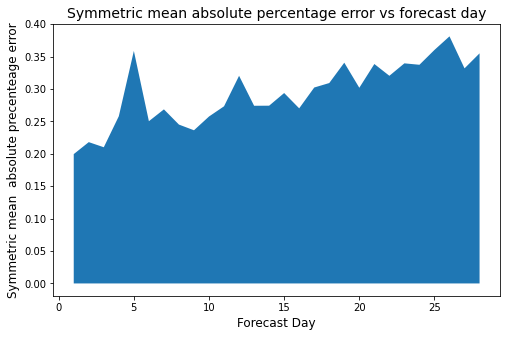

In [ ]:
daily_smape = daily_metrics(daily_prediction, smape_metric)

# Plotting
x = range(1, len(daily_smape)+1)
y = daily_smape
plt.fill_between( x, y)
plt.title('Symmetric mean absolute percentage error vs forecast day', fontsize=14)
plt.xlabel('Forecast Day', fontsize=12)
plt.ylabel('Symmetric mean  absolute precenteage error', fontsize=12);

#### R² score and explained variance score vs forecast day

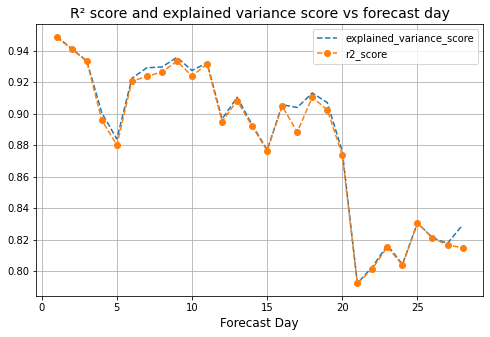

In [ ]:
daily_evs = daily_metrics(daily_prediction, metrics.explained_variance_score)
daily_r2 = daily_metrics(daily_prediction, metrics.r2_score)

# Plotting
x = range(1, len(daily_r2)+1)
plt.plot(x, daily_evs, '--')
plt.plot(x, daily_r2, '--o')
plt.title('R² score and explained variance score vs forecast day', fontsize=14)
plt.xlabel("Forecast Day", fontsize=12)
plt.legend(['explained_variance_score', 'r2_score'])
plt.grid();

#### Scatter of forecasting accuracy (sMAPE) vs traffic volume

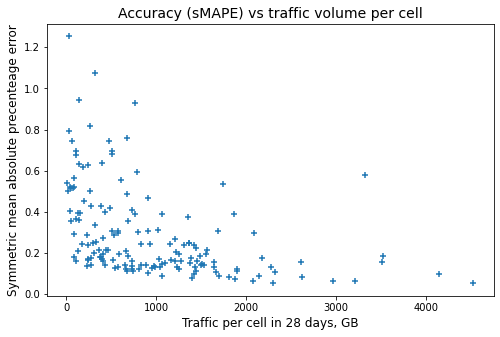

In [ ]:
cell_traffic = []
cell_smape = []

for cell in daily_prediction.Cell.unique():
  temp = daily_prediction[daily_prediction['Cell']==cell].copy()
  cell_traffic.append(temp.y.sum())
  cell_smape.append(smape_metric(temp.y, temp.yhat))

# Plotting
plt.scatter(np.array(cell_traffic)/1024/1024, cell_smape, marker='+')
plt.title('Accuracy (sMAPE) vs traffic volume per cell', fontsize=14)
plt.xlabel('Traffic per cell in 28 days, GB', fontsize=12)
plt.ylabel('Symmetric mean absolute precenteage error', fontsize=12);

## III. Hourly Traffic Trend

### Getting Data

In the second step, using the available 28 days of hourly data

In [ ]:
# Opening daily cell data
hourly_traffic = pd.read_csv('df_hourly.csv', sep=';')

In [ ]:
# Calculating PRB usage
hourly_traffic['PRB_Util_Qty_True'] = hourly_traffic['PRB_Utilization_Percent']*hourly_traffic['PRB_Available_DL']
hourly_traffic['Datetime'] = pd.to_datetime(hourly_traffic['Datetime'])

In [ ]:
# Renaming columns for Prophet standard, where 'ds' its the date
# and 'y' it's a target variable Data_Volume(GB)
hourly_traffic.columns = ['Cell', 'ds', 'y', 'PRB_Available_DL', 'PRB_Utilization_Percent', 'PRB_Util_Qty_True']

In [ ]:
# Checking cell quantity and data range
list_cells = hourly_traffic.Cell.unique()
print(f'Dataset have {len(list_cells)} unique cells',
      f'with date between {min(hourly_traffic.ds)} and {max(hourly_traffic.ds)}.')

Dataset have 163 unique cells with date between 2019-01-01 00:00:00 and 2021-01-28 23:00:00.


In [ ]:
# Splitting dataset
# We will use the same period from daily traffic, except train_ini witch we will use last 30 days
train_ini = datetime.strptime(train_end, "%Y-%m-%d") - timedelta(days=30)
n_hour_forecast = (val_end - datetime.strptime(val_ini, "%Y-%m-%d")).days * 7

df_hourly_train = hourly_traffic[(hourly_traffic['ds'] >= train_ini) & (hourly_traffic['ds'] < train_end)].copy()
df_hourly_val = hourly_traffic[(hourly_traffic['ds'] >= val_ini) & (hourly_traffic['ds'] < val_end)].copy()

df_hourly_train.head()

,Cell,ds,y,PRB_Available_DL,PRB_Utilization_Percent,PRB_Util_Qty_True
1760928,cell0001,2020-06-01 00:00:00,1.158804e+06,100.0,0.096667,9.666667
1760929,cell0001,2020-06-01 01:00:00,4.515076e+05,100.0,0.051667,5.166667
1760930,cell0001,2020-06-01 02:00:00,6.314205e+05,100.0,0.053333,5.333333
1760931,cell0001,2020-06-01 03:00:00,1.551132e+05,100.0,0.050000,5.000000
1760932,cell0001,2020-06-01 04:00:00,1.360913e+04,100.0,0.050000,5.000000


**Note:** As we can se on topic *B. LTE network level throughput to traffic relation*, one of the factors related to the occupation of cell resources is the volume of traffic generated by users. In our studies, we verified that the behavior of this volume throughout the day can be differentiated between weekdays and weekends.

In order to better capture this difference, two conditional columns were included in the dataset, one indicating weekdays and the other indicating weekends. Two custom conditional seasonalities were also added to the algorithm to reflect this difference.

In [ ]:
# Weekend function
def is_weekend(ds):
    date = pd.to_datetime(ds)
    return (date.dayofweek == 5 or date.dayofweek == 6)

In [ ]:
# Creating weekend/weekday columns
df_hourly_train['weekend'] = df_hourly_train['ds'].apply(is_weekend)
df_hourly_train['weekday'] = ~df_hourly_train['ds'].apply(is_weekend)
df_hourly_val['weekend'] = df_hourly_val['ds'].apply(is_weekend)
df_hourly_val['weekday'] = ~df_hourly_val['ds'].apply(is_weekend)

### Forecasting

**Notes:**
1. As we're only interested in hourly traffic distribution between weekdays and weekends, we will use **growth as flat** and choose two days forecast, been one for weekday and one for weekend.
2. In this step we also add more than one configuration to check which one fits best in hourly distribution.

In [ ]:
# Parameters
hourly_params = [
                 # Config01
                 [{'growth': 'flat'},                                                     # Trend growth
                  {'fourier_order': 8, 'mode': 'multiplicative', 'prior_scale': 0.1}],    # Daily Hyperparameters

                 # Config02
                 [{'growth': 'flat'},
                  {'fourier_order': 8, 'mode': 'multiplicative', 'prior_scale': 0.05}],

                 # Config03
                 [{'growth': 'flat'},
                  {'fourier_order': 8, 'mode': 'multiplicative', 'prior_scale': 0.01}]
]

In [ ]:
models_hourly = pd.DataFrame()

for cell in list_cells[:]:

  n_config = 1
  # Filtering cell
  df_train_temp = df_hourly_train[df_hourly_train['Cell']==cell].copy()
  df_val_temp = df_hourly_val[df_hourly_val['Cell']==cell].copy()

  # Applying Box-Cox
  df_train_temp['y'], lambda_prophet = stats.boxcox(df_train_temp['y'])

  # Executing all configurations
  for params in hourly_params:
    config = 'conf_' + str(n_config).zfill(len(str(len(hourly_params))))

    # Instantiating the model
    m = Prophet(yearly_seasonality=False,
                weekly_seasonality=False,
                daily_seasonality=False,
                uncertainty_samples=0,      # Zeroed to speed up forecast
                **params[0])

    # Daily seasonality
    m.add_seasonality(name='daily_weekend', period=1, condition_name='weekend', **params[1])
    m.add_seasonality(name='daily_weekday', period=1, condition_name='weekday', **params[1])

    # Fit
    m.fit(df_train_temp)

    # Create future dataset
    date_range = pd.date_range(start='2017-01-6', periods=48, freq='H')
    future = pd.DataFrame(date_range, columns=['ds'])

    # Creating conditional columns for future dataset
    future['weekend'] = future['ds'].apply(is_weekend)
    future['weekday'] = ~future['ds'].apply(is_weekend)

    # Forecast
    forecast = m.predict(future)

    # Applying inverse Box-Cox in forecast data
    forecast['yhat'] = inverse_boxcox(forecast['yhat'], lambda_prophet)

    # Adding information columns
    forecast['Cell'] = cell
    forecast['weekday'] = ~forecast['ds'].apply(is_weekend)
    forecast['hour'] = forecast['ds'].dt.hour
    forecast['configuration'] = config

    models_hourly = pd.concat([models_hourly,
                               forecast[['Cell', 'weekday', 'hour', 'yhat', 'configuration']]])

    n_config += 1

As we can see below, there are differences in behavior between weekdays and weekend. We will use this in the traffic distribution.

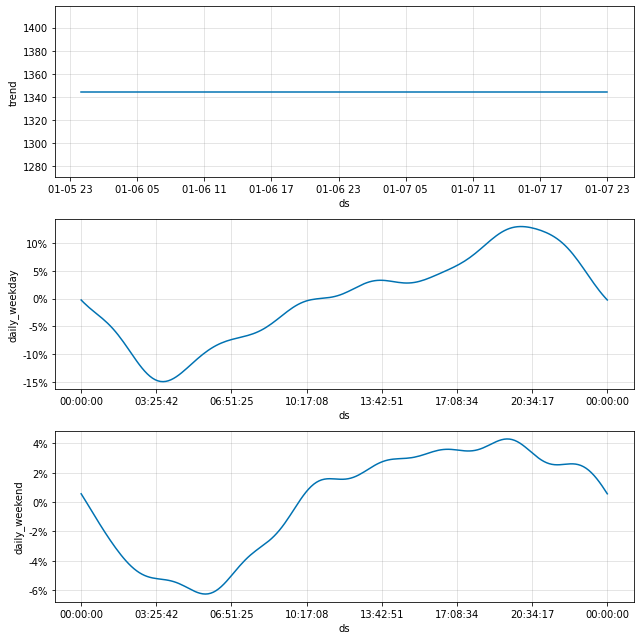

In [ ]:
m.plot_components(forecast);

In [ ]:
# Calculating cell proportional hourly traffic per day and configuration
models_hourly['yhat%'] = models_hourly['yhat'] / models_hourly.groupby(['Cell', 'weekday', 'configuration'])['yhat'].transform('sum')
models_hourly.drop(columns='yhat', inplace=True)

### Peak daily traffic

To obtain peak daily traffic, authors suggest proportionally distributing the hourly prediction values within the predicted 30 days daily traffic. According to them, this method accurately follows real traffic pattern but removes random peaks or decreases and allows to forecast traffic volume for each hour.

In [ ]:
# Getting the quantity and configurations name
n_conf_hourly = len(models_hourly.configuration.unique())
config_name = models_hourly.configuration.unique()

# Creating hourly dataset
final_result_hourly = daily_prediction.drop('y', axis=1)

# Creating hourly column for each cell and configuration
hours_24 = cycle(list(range(0, 24)))
configs = cycle(np.repeat(config_name, 24))

final_result_hourly = pd.DataFrame(np.repeat(final_result_hourly.values, 24 * n_conf_hourly, axis=0),
                                   columns=final_result_hourly.columns)
final_result_hourly['hour'] = [next(hours_24) for hour in range(len(final_result_hourly))]
final_result_hourly['configuration'] = [next(configs) for config in range(len(final_result_hourly))]

# Adding weekday status
final_result_hourly['weekday'] = ~final_result_hourly['ds'].apply(is_weekend)
final_result_hourly.rename(columns={'yhat':'daily_data_volume'}, inplace=True)

We joined daily and hour dataframe considering cell, hour, configuration and weekend/weekday status.

In [ ]:
# Merging daily prediction with hourly prediction
final_result_hourly = final_result_hourly.merge(models_hourly,
                                                on=['Cell', 'weekday', 'hour', 'configuration'],
                                                how='left')

# Distributing the hourly prediction values within the predicted daily traffic
final_result_hourly['yhat'] = final_result_hourly['daily_data_volume'] * final_result_hourly['yhat%']

final_result_hourly.rename(columns={'ds':'day'}, inplace=True)

# Creating timestamp
final_result_hourly['ds'] = final_result_hourly['day'] + final_result_hourly.hour.astype('timedelta64[h]')

In [ ]:
final_result_hourly = pd.merge(final_result_hourly[['Cell', 'day', 'ds', 'yhat',
                                                    'configuration', 'daily_data_volume', 'yhat%']],
                               df_hourly_val.drop(['weekend', 'weekday'], axis=1),
                               left_on=['Cell', 'ds'],
                               right_on=['Cell', 'ds'],
                               how='inner')
final_result_hourly = final_result_hourly.sort_values(by = ['Cell', 'configuration', 'ds']).copy()

### Evaluating

**Note:** Authors didn't perform precision measurements in this phase of study, nevertheless, I've inserted the measurements presented in the previous topic, with this, it's possible to choose the model configuration that best fit the validation data.

#### LTE Traffic Forecasting Accuracy Overall Result

In [ ]:
# Eveluating results for each configuration
evaluating_cols = metric_cols + ['Configuration']
overall_result_hourly = pd.DataFrame(columns= evaluating_cols)
full_eval = []
hourly_configurations = final_result_hourly.configuration.unique()

for configuration in hourly_configurations:
  temp_df = final_result_hourly[final_result_hourly['configuration']==configuration].copy()

  temp_df.dropna(inplace=True)   # Delete this line

  temp_eval = timeseries_evaluation_metrics_func(temp_df.y, temp_df.yhat)
  temp_eval.append(configuration)
  full_eval.append(temp_eval)

overall_result_hourly = pd.concat([overall_result_hourly,
                                  pd.DataFrame(full_eval, columns= evaluating_cols)])
overall_result_hourly

,sMAPE,EVS,R2,Configuration
0,0.478260,0.820387,0.819381,conf_1
1,0.482540,0.820672,0.819665,conf_2
2,0.631291,0.642894,0.641886,conf_3


In [ ]:
# Eveluating results for each configuration
evaluating_cols_1 = metric_cols + ['Configuration', 'cell']
individual_result_hourly = pd.DataFrame(columns=evaluating_cols_1)
ind_eval = []
hourly_configurations = final_result_hourly.configuration.unique()
cells_eval = final_result_hourly['Cell'].unique()

for cell in cells_eval:
  temp_cell_df = final_result_hourly[final_result_hourly['Cell']==cell]

  for configuration in hourly_configurations:
    temp_df = temp_cell_df[temp_cell_df['configuration']==configuration]
    temp_eval = timeseries_evaluation_metrics_func(temp_df.y, temp_df.yhat)
    temp_eval.append(configuration)
    temp_eval.append(cell)
    ind_eval.append(temp_eval)

individual_result_hourly = pd.concat([individual_result_hourly,
                                  pd.DataFrame(ind_eval, columns= evaluating_cols_1)])

**Note:** After run all desired configurations, pick one that best performed. This one will be used further, in the final solution.

In [ ]:
hourly_prediction = final_result_hourly[final_result_hourly['configuration']=='conf_2'].copy().reset_index(drop=True)
hourly_prediction.drop(['configuration'], axis=1, inplace=True)

# Calculating daily traffic %
hourly_prediction['y%'] = hourly_prediction['y'] / hourly_prediction.groupby(['Cell', 'day'])['y'].transform('sum')

#### LTE cell traffic  compared to traffic trend modeled

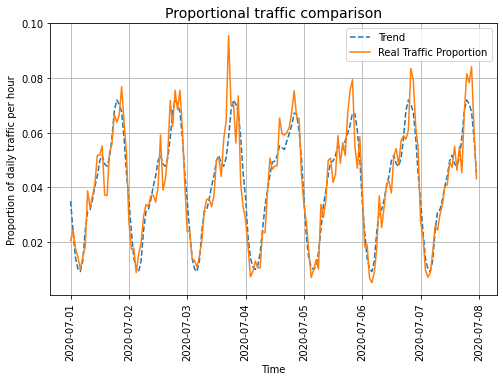

In [ ]:
example_cell = hourly_prediction[hourly_prediction['Cell']=='cell0012']
example_cell = example_cell.head(24*7)

plt.plot(example_cell.ds, example_cell['yhat%'], '--', label='Trend')
plt.plot(example_cell.ds, example_cell['y%'], label='Real Traffic Proportion')

plt.title('Proportional traffic comparison', fontsize=14)
plt.xlabel("Time", fontsize=10)
plt.ylabel("Proportion of daily traffic per hour", fontsize=10)
plt.xticks(rotation=90)
plt.legend()
plt.grid();

## IV. LTE Cell Capacity Evaluation

### Espectral efficiency

Each cell has a unique behavior regard to reaching the threshold. This is defined by the spectral efficiency. The authors suggest to evaluate the cells individually and, through linear regression, verify the traffic demand that each cell supports before reaching the PRB utilization threshold.

#### Example of LTE cells with different spectral efficiency

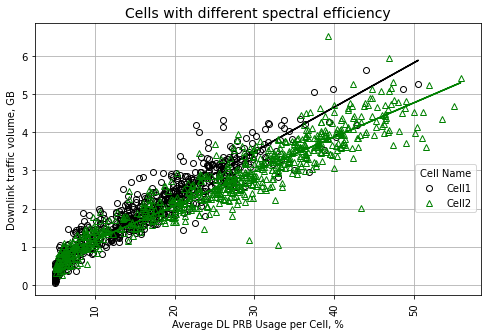

In [ ]:
cell_a, cell_b = 'cell0015', 'cell0020'

cell_a_x = df_hourly_train[df_hourly_train['Cell']==cell_a].PRB_Utilization_Percent*100
cell_a_y = (df_hourly_train[df_hourly_train['Cell']==cell_a].y)/1024/1024
cell_b_x = df_hourly_train[df_hourly_train['Cell']==cell_b].PRB_Utilization_Percent*100
cell_b_y = (df_hourly_train[df_hourly_train['Cell']==cell_b].y)/1024/1024

plt.plot(cell_a_x, cell_a_y, 'o', mfc='none', label='Cell1', c='k')
m, b = np.polyfit(cell_a_x, cell_a_y, 1)
plt.plot(cell_a_x, m*cell_a_x+b, c='k')

plt.plot(cell_b_x, cell_b_y, '^', mfc='none', label='Cell2', c='g')
m, b = np.polyfit(cell_b_x, cell_b_y, 1)
plt.plot(cell_b_x, m*cell_b_x+b, c='g')

plt.title('Cells with different spectral efficiency', fontsize=14)
plt.xlabel("Average DL PRB Usage per Cell, %", fontsize=10)
plt.ylabel("Downlink traffic volume, GB", fontsize=10)
plt.xticks(rotation=90)
plt.legend(title="Cell Name", bbox_to_anchor=(1, 0.5))
plt.grid();

### Calculation of spectral efficiency for each cell using regression

In [ ]:
prb_util_prediction = pd.DataFrame()
cell_coefficients = []

for cell in list_cells[:]:
  df_train_temp = df_hourly_train[df_hourly_train['Cell']==cell].copy()

  # Regression between Data Volume and PRB_Utilization_Qty on train dataset
  x = df_train_temp['y']
  y = df_train_temp['PRB_Util_Qty_True']
  var_lin = np.polyfit(x, y, 1) # Getting the coefficients
  cell_coefficients.append([cell, var_lin[0], var_lin[1]])

  # Calculating PRB usage
  df_test_temp = hourly_prediction[hourly_prediction['Cell']==cell].copy()
  df_test_temp['PRB_Util_Qty_Pred'] = np.array([var_lin[0]*val+var_lin[1] for val in df_test_temp.yhat])

  prb_util_prediction = pd.concat([prb_util_prediction, df_test_temp])

prb_util_prediction['PRB_Util_Perc_Pred'] = prb_util_prediction['PRB_Util_Qty_Pred']/prb_util_prediction['PRB_Available_DL']

### Congestion Threshold

Authors found a strong correlation between the utilization of PRBs (physical resource block) and average user throughput. They suggest that hourly samples that had 20 or fewer unused PRBs were considered congested:

> *LTE 800MHz cell with 10MHz bandwidth can be considered as loaded if utilization is 60% or 20 PRB unused, and LTE 1800MHz with 20MHz bandwidth PRB utilization is above 80% (20 PRB left)* - Chmieliauskas & Guršnys, 2020

To simplify our calculations, we adopt as congested hourly samples over 70% PRB utilization, as shown below.

|Bandwidth (MHz)|PRB Available|Threshold (70% usage)|PRB unused|
|:---: |:---: |:---: |:---: |
|1,4|	6	|4	|2  |
|3	|15	|10	|5  |
|5	|25	|17	|8  |
|10	|50	|35	|15 |
|15	|75	|52	|23 |
|20	|100|70	|30 |

In [ ]:
# Calculating congestion samples
cong_threshold = 0.6

prb_util_prediction['Cong_True'] = prb_util_prediction.PRB_Utilization_Percent >= cong_threshold
prb_util_prediction['Cong_Pred'] = prb_util_prediction.PRB_Util_Qty_Pred / prb_util_prediction.PRB_Available_DL >= cong_threshold

In [ ]:
# Renaming and organizing columns
prb_util_prediction.rename(columns={'yhat':'daily_data_vol_pred',
                                    'yhat%': 'daily_data_vol_pred%',
                                    'y': 'daily_data_vol_true',
                                    'y%': 'daily_data_vol_true%',
                                    'PRB_Utilization_Percent': 'PRB_Util_%_True'}, inplace=True)

prb_util_prediction['weekend'] = prb_util_prediction['ds'].apply(is_weekend)

prb_util_prediction = prb_util_prediction[['Cell', 'day', 'ds', 'weekend', 'daily_data_vol_true',
                                           'daily_data_vol_true%', 'daily_data_vol_pred',
                                           'daily_data_vol_pred%', 'PRB_Available_DL',
                                           'PRB_Util_Qty_True', 'PRB_Util_%_True',
                                           'PRB_Util_Qty_Pred', 'PRB_Util_Perc_Pred',
                                           'Cong_True', 'Cong_Pred']]

### Evaluating

The ultimate purpose of this study is to identify the cells that will show the highest congestion sampling. As mentioned before, there are cells that have greater use characteristics on weekdays, such as cells in the city center and others with greater use on weekends, such as cells in residential neighborhoods. As a filter, we will consider as congested the cells that present an average of 1 or more daily samples of congestion, as follows:

$
Congestioned \ cell =   
  \begin{cases}
    1  & \quad \text{for weekdays } n \text{ cong. samples} \geq n \text{ weekdays or}    \\
    & \quad \text{weekends } n \text{ cong. samples} \geq n \text{ weekends}    \\
    0  & \quad \text{otherwise}
  \end{cases}
$

In [ ]:
pred_congestion_eval = pd.pivot_table(prb_util_prediction, values=['Cong_Pred', 'Cong_True'],
                                      index='Cell', columns='weekend', aggfunc='sum')
pred_congestion_eval = pred_congestion_eval.droplevel(0, axis=1).reset_index()
pred_congestion_eval.columns = ['Cell', 'Cong_pred_weekday','Cong_pred_weekend','Cong_true_weekday','Cong_true_weekend']

pred_congestion_eval.head(15)

,Cell,Cong_pred_weekday,Cong_pred_weekend,Cong_true_weekday,Cong_true_weekend
0,cell0001,0,0,0,0
1,cell0002,0,0,0,1
2,cell0003,0,0,0,0
3,cell0004,0,0,0,0
4,cell0006,0,0,1,0
5,cell0007,0,0,61,0
6,cell0008,0,0,6,0
7,cell0009,0,0,0,0
8,cell0010,0,0,0,0
9,cell0011,0,0,1,0


## V. Conclusions

As stated at the beginning of this study, the main objective of this work is to replicate the work done by D. Chmieliauskas and D. Guršnys in order to make the code available on paperswithcode.com. Some improvements were suggested throughout this work, such as data transformation through box-cox, the utilization of a 1.5-year data history to capture annual seasonality, the differentiation of data between weekdays and weekends to better capture individual cell characteristics, and finally, the use of the sMAPE indicator due to its robustness to outliers. The results obtained in this work were not satisfactory; however, since there was no tuning performed, it is possible to improve them.

---